---
title: "Curriculum Learning 🤝 DSPy: Modelling"
author: Shubham Gupta
date: '2025-09-01'
image: ../cl_dspy/submission_mlflow_traces.png
description: Mapping ConvFinQA and crafting a curriculum for financial QA
lightbox: true
toc: true
footnotes-hover: false
resources:
  - _2025-09-01-cl-dspy-modelling.html 
  - 2025-09-01-cl-dspy-modelling_files/*
redirect: _2025-09-01-cl-dspy-modelling.html
categories:
- programming
- dspy
- curriculum-learning
freeze: true
---

In our [previous exploration](../2025-08-31-cl-dspy-eda.ipynb), we analyzed 3,458 ConvFinQA records and established a curriculum learning framework with three difficulty stages: **Easy** (≤2 ops, simple context), **Medium** (2-3 ops, moderate complexity), and **Hard** (≥4 ops, complex multi-turn reasoning). 

Now it's time to put this curriculum to work by implementing and evaluating our models.

## From Prompting to Programming

Traditionally, LLM applications rely on hand-rolled prompts—carefully crafted text instructions that are often brittle and difficult to optimize, especially for complex multi-step reasoning tasks like financial QA.

Our curriculum learning approach demands systematic experimentation across models, difficulty levels, and optimization strategies. This makes DSPy the ideal framework, as it transforms prompting from an art into systematic, testable code.

**Why DSPy for curriculum learning?**

- **Reproducible experiments**: Prompts become Python objects → diffable, unit-testable, version-controlled
- **Optimization**: Built-in optimizers (LabeledFewShot, BootstrapFewShot) auto-search the prompt space across our curriculum stages
- **Clean evaluation pipeline**: First-class metrics support—plug in exact match, hit .compile(), get train/val loops with curriculum-aware sampling
- **Model flexibility**: Test curriculum effects across GPT-4, o4-mini, Gemini, and open-source models with one-line swaps
- **Efficient iteration**: Caching and threading speed up development cycles crucial for curriculum experiments

This approach lets us test whether our Easy→Medium→Hard curriculum improves financial reasoning compared to random sampling.

## Evaluation Metrics

For this exploratory analysis, we need a clear metric to measure model performance across our curriculum learning experiments. Following the original ConvFinQA paper, we adopt **Exact Match (EM)** as our primary evaluation metric.

### Primary Metric: Turn-level EM

**Turn-level EM** measures whether the generated answer for a specific dialogue turn exactly matches the gold standard answer. This binary metric (1 for exact match, 0 otherwise) provides a strict but interpretable measure of performance that directly aligns with the task requirements.

We choose this as our primary metric for several reasons:
- **Simplicity**: Easy to implement and interpret for initial experimentation
- **Strictness**: Financial reasoning requires precision—approximate answers can be misleading
- **Comparability**: Direct comparison with baseline results from the original paper
- **Curriculum sensitivity**: Clear signal for measuring improvement across difficulty levels

### Additional Metrics (Future Work)

There are several other metrics could be useful:

**Conversation-level metrics** like Dialogue Mean EM and Joint EM would better capture multi-turn reasoning dependencies, but add complexity to curriculum design. Since our curriculum is based on individual example difficulty rather than conversation-level complexity, turn-level metrics are more appropriate for this phase.

**Diagnostic metrics** such as Exec-agree % and numeric error analysis would help distinguish between reasoning failures and execution errors. However, for establishing whether curriculum learning improves over random sampling, the binary success signal from exact match provides sufficient discriminative power.

**Efficiency metrics** like program length and evidence tokens could reveal interesting patterns about how curriculum learning affects model behavior, but are secondary to establishing basic performance improvements.

We've skipped the other metrics for now for the sake of brevity.

## Model List

We will consider the following _families_ of models:

| Family | Rationale | Benchmarked Checkpoints |
|--------|-----------|-------------------------|
| **Non-Reasoning** | Classic next-token predictors. Useful as baselines for curriculum-learning because they expose the value of explicit reasoning. | • `openai/gpt-4.1-2025-04-14`  <br>• `openai/gpt-4.1-mini-2025-04-14` |
| **Reasoning** | Architected for multi-step, chain-of-thought inference. Expected to excel once the curriculum introduces compositional tasks. | • `openai/o4-mini-2025-04-16` <br>• `anthropic/claude-sonnet-4-20250514` <br>• `gemini-2.5-flash` <br>• `gemini-2.5-flash-lite` |
| **Frontier** | Flagship models from frontier labs. Highest quality but costly—kept only for upper-bound comparisons, not final deployment. | • `openai/o3-2025-04-16` <br>• `anthropic/claude-opus-4-20250514` <br>• `gemini-2.5-pro` |
| **Open-Source** | Critical for cost-sensitive deployments(an OS models FTW). Benchmarked to quantify the closed–open gap. | • `qwen3-32b` |

### Two-Stage Gating Protocol

1. **Gate**  
   • Dataset: 50 “Easy” teacher-forced dialogues  
   • Retain a model only if **Turn-EM ≥ 0.55**

2. **Probe**  
   • Dataset: 30 dialogues (15 Medium + 15 Hard), closed-loop  
   • Retain a model only if **Final-Turn EM ≥ 0.35** _and_ **Dialogue-mean EM ≥ 0.35**

This pipeline quickly eliminates weak candidates while preserving models whose strengths surface in longer, reasoning-heavy contexts.

### Experiment Tracking

All training and evaluation runs are logged with **MLflow**:

- MLflow Tracking – run metadata, metrics, and artifacts for DSPy experiments  
- MLflow Model – package DSPy programs for reproducible rollout  
- MLflow Evaluate – built-in GenAI evaluators for rapid iteration  
- MLflow Tracing – one-line capture of DSPy internals for debugging

In production, the deployment pipeline would look as follows:

<p align="center">,
  <img src="../cl_dspy/mlflow_dspy.png" alt="DSPy Production deployment with MLFlow. Source: DSPy Docs" width="200" height="300"/>,
  <br>,
  <sub>,
    DSPy Production deployment with MLFlow. Source: <a href="https://mlflow.org/docs/latest/genai/flavors/dspy/">MLFlow Docs</a>,
  </sub>,
</p>



## Setup

In [ ]:
import mlflow
from IPython.display import IFrame, HTML, display

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.dspy.autolog(log_compiles=True, log_evals=True, log_traces_from_compile=True)
result = mlflow.set_experiment("DSPy")

# Display MLFlow UI in an iframe to prevent HTML document conflicts
print(f"Experiment: {result.name} (ID: {result.experiment_id})")
display(HTML(f'<p><a href="http://localhost:5000/#/experiments/{result.experiment_id}" target="_blank">View MLFlow Experiment UI</a></p>'))


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1753611058221, experiment_id='1', last_update_time=1753611058221, lifecycle_stage='active', name='DSPy', tags={}>

In [3]:
import os

import dotenv
import dspy

dotenv.load_dotenv("../.env")
MAX_TOKENS = 20_000

lm_oai_gpt_4_1 = dspy.LM(
    "openai/gpt-4.1-2025-04-14",
    api_key=os.environ["OPENAI_API_KEY"],
    max_tokens=MAX_TOKENS,
)
lm_oai_gpt_4_1_mini = dspy.LM(
    "openai/gpt-4.1-mini-2025-04-14",
    api_key=os.environ["OPENAI_API_KEY"],
    max_tokens=MAX_TOKENS,
)

lm_oai_o4_mini = dspy.LM(
    "openai/o4-mini-2025-04-16",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=1.0,
    max_tokens=MAX_TOKENS,
)
lm_anthropic_sonnet_4_0 = dspy.LM(
    "anthropic/claude-sonnet-4-20250514",
    api_key=os.environ["ANTHROPIC_API_KEY"],
    max_tokens=MAX_TOKENS,
)
lm_gemini_flash_2_5 = dspy.LM(
    "gemini/gemini-2.5-flash",
    api_key=os.environ["GEMINI_API_KEY"],
    max_tokens=MAX_TOKENS,
)
lm_gemini_flash_2_5_lite = dspy.LM(
    "gemini/gemini-2.5-flash-lite",
    api_key=os.environ["GEMINI_API_KEY"],
    max_tokens=MAX_TOKENS,
)

lm_oai_o3 = dspy.LM(
    "openai/o3-2025-04-16",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=1.0,
    max_tokens=MAX_TOKENS,
)
lm_anthropic_opus_4_0 = dspy.LM(
    "anthropic/claude-opus-4-20250514",
    api_key=os.environ["ANTHROPIC_API_KEY"],
    max_tokens=MAX_TOKENS,
)
lm_gemini_pro_2_5 = dspy.LM(
    "gemini/gemini-2.5-pro",
    api_key=os.environ["GEMINI_API_KEY"],
    max_tokens=MAX_TOKENS,
)

lm_qwen3_32b = dspy.LM(
    "ollama/qwen3:32b",
    api_base="http://localhost:11434",
    api_key="",
    max_tokens=MAX_TOKENS,
)


In [10]:
import dspy

llms = [
    lm_oai_gpt_4_1,
    lm_oai_gpt_4_1_mini,
    lm_oai_o4_mini,
    lm_anthropic_sonnet_4_0,
    lm_gemini_flash_2_5,
    lm_gemini_flash_2_5_lite,
    lm_oai_o3,
    lm_anthropic_opus_4_0,
    lm_gemini_pro_2_5,
    lm_qwen3_32b,
]


class Echo(dspy.Signature):
    """Echoes the input prompt."""

    prompt = dspy.InputField()
    output = dspy.OutputField()


with mlflow.start_run(run_name="Setup") as run:
    for lm in llms:
        try:
            with dspy.context(lm=lm, track_usage=True, cache=True):
                if lm in [lm_oai_gpt_4_1, lm_oai_gpt_4_1_mini]:
                    program = dspy.Predict("instruction -> answer")
                else:
                    program = dspy.ChainOfThought("instruction -> answer")
                response = program(instruction="What is the date?")
                if getattr(response, "reasoning", None):
                    print(f"{lm.model} Reasoning: {response.reasoning}")
                print(f"{lm.model}: {response.answer}")
        except Exception as e:
            print(f"{getattr(lm, 'model', lm)}: ERROR - {e}")


openai/gpt-4.1-2025-04-14: Today's date is June 13, 2024.
openai/gpt-4.1-mini-2025-04-14: The current date is June 15, 2024.
openai/o4-mini-2025-04-16 Reasoning: The user asked for the current date. I will provide today's date in a clear, human-readable format.
openai/o4-mini-2025-04-16: The current date is May 30, 2024.
anthropic/claude-sonnet-4-20250514 Reasoning: The user is asking for the current date. However, I don't have access to real-time information or the ability to know what the current date is. I should explain that I cannot provide the current date and suggest how they can find this information.
anthropic/claude-sonnet-4-20250514: I don't have access to real-time information, so I cannot tell you the current date. To find today's date, you can:
- Check your computer, phone, or other device
- Search "what is today's date" in a search engine
- Ask a voice assistant like Siri, Alexa, or Google Assistant
gemini/gemini-2.5-flash Reasoning: The user is asking for the current da

[Trace(trace_id=3be570b5035f48159f5f6f8b102b3565), Trace(trace_id=5ef345c76c844b5786e8d8d54b9de2c6), Trace(trace_id=9e5a6b35374a4fbc8cbc10bcf48a9765), Trace(trace_id=f54a2f585a8248feb6f8b0e56b6821ca), Trace(trace_id=7d0291783ca34ac3a2304daa01790993), Trace(trace_id=7d7c7c7e1e534a6abdcba8718079d6e1), Trace(trace_id=0a13673c74a146c4b6fdbfde935a0390), Trace(trace_id=0e3ebc3c4d1d4d4e8b2cef92e92d608a), Trace(trace_id=c5866268627d4319a05eb6af34b78672), Trace(trace_id=1f253b525ef547649472ffd87573560d)]

In [11]:
import json

data = json.load(open("../data/convfinqa_dataset.json"))

## Model Selection

In the **easy** problems stage, we will select a relatively straightforward implementation. Specifically, we will provide the model with all context, and ask it to answer the question in a zero-shot manner. 

This will help us identify strong baseline performance, and identify any issues with the model's ability to understand the problem.

First, we will create the DSPy signatures for our dataset.
Signatures are used to define the input and output of a model.

Specifically, we will have two types of signatures: one that doesn't support reasoning model(for direct prediction models like GPT-4.1), and one that does support reasoning mode(for the reasoning models like o3, gemini pro, etc.)

In [260]:
class SolveTurnWithoutReasoning(dspy.Signature):
    conversation_context: str = dspy.InputField(desc="Conversation so far")
    evidence_snippets: str = dspy.InputField(
        desc="Snippets of evidence surrounding the table"
    )
    table: str = dspy.InputField(desc="Input financial table with metrics")
    question: str = dspy.InputField(desc="Question to answer")

    ops: str = dspy.OutputField(
        desc="Comma-separated ConvFinQA DSL program. Allowed ops: add(x, y), subtract(x, y), multiply(x, y), divide(x, y), exp(x, y), greater(x, y). Args may be constants (e.g., const_100), numbers (int or float), or prior step refs (#0, #1…). Order always follows the pattern x <op> y—pick x and y deliberately. Example: subtract(const_100, 42), divide(#0, 3.14). Convert to percentages only if explicitly asked in the question."
    )
    answer: str = dspy.OutputField(
        desc="Final answer. This will be a single number, or a boolean string(yes/no)"
    )


class SolveTurnWithReasoning(dspy.Signature):
    conversation_context: str = dspy.InputField(desc="Conversation so far")
    evidence_snippets: str = dspy.InputField(
        desc="Snippets of evidence surrounding the table"
    )
    table: str = dspy.InputField(desc="Input financial table with metrics")
    question: str = dspy.InputField(desc="Question to answer")

    reasoning: str = dspy.OutputField(
        desc="Reasoning behind the answer. Carefully analyze the conversation_context, and especially the evidence_snippets and table for the given question, and generate your reasoning before generating the ops and answer."
    )
    ops: str = dspy.OutputField(
        desc="Comma-separated ConvFinQA DSL program. Allowed ops: add(x, y), subtract(x, y), multiply(x, y), divide(x, y), exp(x, y), greater(x, y). Args may be constants (e.g., const_100), numbers (int or float), or prior step refs (#0, #1…). Order always follows the pattern x <op> y—pick x and y deliberately. Example: subtract(const_100, 42), divide(#0, 3.14). Convert to percentages only if explicitly asked in the question."
    )
    answer: str = dspy.OutputField(
        desc="Final answer. This will be a single number, or a boolean string(yes/no)"
    )


class TurnSolver(dspy.Module):
    """
    In the context of this series of interconnected finance-related queries and the additional information provided by the pretext, table data, and posttext from a company's financial filings, please provide a response to the final question. This may require extracting information from the context and performing mathematical calculations. Please take into account the information provided in the preceding questions and their answers when formulating your response: \n\n
    """

    def __init__(self, reasoning_lm=False):
        super().__init__()
        if reasoning_lm:
            self.pred = dspy.ChainOfThought(SolveTurnWithReasoning)
        else:
            self.pred = dspy.Predict(SolveTurnWithoutReasoning)

    def forward(self, conversation_context, evidence_snippets, table, question):
        """
        Run the model to solve a single turn.

        Args:
            conversation_context (str): Conversation so far.
            evidence_snippets (str): Evidence text around the table.
            table (str): Financial table in markdown.
            question (str): Question to answer.

        Returns:
            dspy.Prediction: Model output with reasoning, ops, and answer.
        """
        return self.pred(
            conversation_context=conversation_context,
            evidence_snippets=evidence_snippets,
            table=table,
            question=question,
        )


Next, we define a few helper functions to format our dataset for the DSPy model.
We intentionally don't spend too much time here for now, and will come back to this later, during the _optimization_ phase.

In [405]:
def norm_ans(x):
    """
    Normalize an answer for comparison.

    Converts input to string, strips whitespace, removes percent signs,
    and attempts to cast to float. If conversion fails, returns the cleaned string.

    Args:
        x: The answer to normalize (str, float, or int).

    Returns:
        float or str: Normalized float if possible, else cleaned string.
    """
    s = str(x).strip().replace("%", "")
    try:
        return float(s)
    except Exception:
        return s


def _table_md(table_dict: dict, max_cols: int | None = None) -> str:
    """
    Convert a dictionarised table to compact GitHub-markdown.

    Accepted shapes
    1) {row_name: {col_name: value, …}, …}   # regular 2-level mapping
    2) {col_name: value, …}                  # flat → coerced to single row

    Guarantees
    • Original row order is kept.
    • Column headers are kept in *first-seen* order; NO deduplication.
    • max_cols (if given) truncates *after* enumeration, duplicates included.
    • None → "" and everything else is str()-ed.
    """
    if not table_dict:
        return ""

    if all(not isinstance(v, dict) for v in table_dict.values()):
        # flat mapping → one anonymous row
        table_dict = {"": dict(table_dict)}
    else:
        # ensure every value is a dict
        table_dict = {
            r: (v if isinstance(v, dict) else {"": v}) for r, v in table_dict.items()
        }

    row_ids = list(table_dict.keys())  # preserve caller order

    cols: list = []
    for r in row_ids:
        cols.extend(table_dict[r].keys())
    if max_cols is not None:
        cols = cols[:max_cols]

    header = "| Row | " + " | ".join(map(str, cols)) + " |"
    sep = "|" + "---|" * (len(cols) + 1)
    lines = [header, sep]

    for r in row_ids:
        vals = [str(table_dict[r].get(c, "")) for c in cols]
        lines.append("| " + str(r) + " | " + " | ".join(vals) + " |")

    return "\n".join(lines)


def build_inputs_from_row(
    row,
    turn_idx,
    *,
    history_mode: str = "teacher",
    state: dict | None = None,
    max_table_cols: int = 100,
):
    """
    history_mode: 'teacher' | 'model' | 'none'
    state: carries model predictions across turns when history_mode='model'
           expected keys: {'pred_answers': list[str|float]}
    evidence_builder: optional callable(row, turn_idx)->str; if None, use simple truncation.
    """
    qs = row["dialogue_conv_questions"]
    gold = row["dialogue_executed_answers"]

    # ---- history ----
    history_lines = []
    for t in range(turn_idx):
        history_lines.append(f"Q{t + 1}: {qs[t]}")
        if history_mode == "teacher":
            history_lines.append(f"A{t + 1}: {gold[t]}")
        elif (
            history_mode == "model" and state and len(state.get("pred_answers", [])) > t
        ):
            history_lines.append(f"A{t + 1}: {state['pred_answers'][t]}")
        elif history_mode == "none":
            pass  # only questions
    conversation_context = "\n".join(history_lines) if history_lines else "None"

    # compact pre/post: first N sentences
    # def first_sents(txt, n):
    #     if not txt: return ""
    #     # very light sentence split
    #     parts = [p.strip() for p in txt.split(". ") if p.strip()]
    #     return ". ".join(parts[:n])
    # pre = first_sents(row.get("doc_pre_text", "") or "", max_pre_sents)
    # post= first_sents(row.get("doc_post_text", "") or "", max_post_sents)
    # evidence_snippets = f"[PRE]\n{pre}\n[/PRE]\n[POST]\n{post}\n[/POST]"
    evidence_snippets = (
        f"[PRE]\n{row['doc_pre_text']}\n[/PRE]\n[POST]\n{row['doc_post_text']}\n[/POST]"
    )
    table_md = _table_md(row.get("doc_table", {}) or {}, max_cols=max_table_cols)

    return dict(
        conversation_context=conversation_context,
        evidence_snippets=evidence_snippets,
        table=table_md,
        question=qs[turn_idx],
        **row,
    )


In [406]:
def evaluate_dialogues(model, df):
    """
    Evaluate a dialogue model on a DataFrame of conversations.

    Args:
        model: Callable that takes unpacked input dict and returns an object with at least `.answer` (and optionally `.ops`).
        df: pd.DataFrame with columns:
            - "dialogue_conv_questions": list of str, all questions in the conversation
            - "dialogue_executed_answers": list of str/float, all executed answers so far
            - (other columns as needed by evidence_builder)

    Returns:
        dict with:
            - "turn_em_micro": float, micro-averaged exact match over all turns
            - "dlg_mean_em_macro": float, macro-averaged mean EM per dialogue
            - "joint_em": float, fraction of dialogues with all turns correct
            - "final_turn_em": float, EM on the final turn of each dialogue
            - "n_dialogues": int, number of dialogues
            - "n_turns": int, total number of turns
    """
    turn_hits = 0
    turn_tot = 0
    # exec_hits = 0
    dlg_mean_ems = []
    dlg_joint_hits = 0
    final_hits = 0

    for _, row in df.iterrows():
        qs = row["dialogue_conv_questions"]
        gold = row["dialogue_executed_answers"]
        ems = []
        exec_flags = []
        for t in range(len(qs)):
            inp = build_inputs_from_row(row, t)
            out = model(**inp)  # out.ops, out.answer
            pa = norm_ans(out.answer)
            ga = norm_ans(gold[t])
            em = float(pa == ga)
            ems.append(em)
            turn_hits += em
            turn_tot += 1

            # (optional) exec check if you have your python DSL evaluator:
            # exec_ok = False
            # try:
            #     # exec_ok = (run_dsl(out.ops, inp) == ga)   # plug your interpreter
            #     exec_ok = False
            # except Exception:
            #     exec_ok = False
            # exec_flags.append(exec_ok)
            # exec_hits += float(exec_ok)

        dlg_mean_ems.append(sum(ems) / len(ems))
        if all(v == 1.0 for v in ems):
            dlg_joint_hits += 1
        final_hits += ems[-1]

    return {
        "turn_em_micro": turn_hits / max(1, turn_tot),
        "dlg_mean_em_macro": sum(dlg_mean_ems) / max(1, len(dlg_mean_ems)),
        "joint_em": dlg_joint_hits / max(1, len(dlg_mean_ems)),
        "final_turn_em": final_hits / max(1, len(dlg_mean_ems)),
        # "exec_agree_rate": exec_hits / max(1, turn_tot),
        "n_dialogues": len(dlg_mean_ems),
        "n_turns": turn_tot,
    }


Next, we will create the DSPy metric, used to _evaluate_ the performance of our model.

We will focus on 2 parts to our metric:
- If the answer is a floating point number, we will aim to compare it with the ground truth with some tolerance.
- If the answer is a string, we will aim to perform **exact match** via DSPy's `exact_match` metric.


In [407]:
def turn_em_metric(example, pred, trace=None):
    """
    Compute turn-level exact match (EM) metric for a single example/prediction pair.

    Args:
        example: dict-like, must contain "gold_answer" key.
        pred: object with an "answer" attribute.

    Returns:
        float: 1.0 if normalized prediction matches normalized gold answer (with tolerance for floats), else 0.0.
    """
    from dspy.evaluate.metrics import answer_exact_match

    pa = norm_ans(pred.answer)
    ga = norm_ans(example["answer"])
    if isinstance(pa, float) and isinstance(ga, float):
        return float(abs(pa - ga) <= 1e-2)
    else:
        # exact_match in DSPy needs the inputs to be in string format
        # due to the normalisations DSPy performs internally.
        ground_truth = dspy.Prediction(answer=str(example.answer))
        pred_answer = dspy.Prediction(answer=str(pred.answer))
        return float(answer_exact_match(ground_truth, pred_answer))

In [408]:
def to_turn_examples(df, history_mode="teacher"):
    examples = []
    for _, row in df.iterrows():
        qs = row["dialogue_conv_questions"]
        gold = row["dialogue_executed_answers"]
        for t in range(len(qs)):
            inp = build_inputs_from_row(row, t, history_mode=history_mode)
            ex = dict(**inp, answer=gold[t])
            examples.append(
                dspy.Example(**ex).with_inputs(
                    "conversation_context",
                    "evidence_snippets",
                    "table",
                    "question",
                )
            )
    return examples


Next, we will prepare our datasets.

We will aim to use the splits as follows:
- `train`: Used primarily for the _optimisation_ phase. This will be discussed shortly.
- `valid`: Used to evaluate the performance of an LM on an optimised model _trained_ using the train dataset.
- `test`: Used to evaluate the performance of an LM on a held-out dataset. This will determine the overall stage performance.


In [409]:
import pandas as pd

train_df = pd.DataFrame(data["train"])
test_df = pd.DataFrame(data["dev"])

In [410]:
# Flatten features to remove the indexing gymnastics
train_flat_df = pd.concat(
    [
        train_df.drop(["doc", "dialogue", "features"], axis=1),
        train_df["doc"].apply(pd.Series).add_prefix("doc_"),
        train_df["dialogue"].apply(pd.Series).add_prefix("dialogue_"),
        train_df["features"].apply(pd.Series).add_prefix("features_"),
    ],
    axis=1,
)

test_flat_df = pd.concat(
    [
        test_df.drop(["doc", "dialogue", "features"], axis=1),
        test_df["doc"].apply(pd.Series).add_prefix("doc_"),
        test_df["dialogue"].apply(pd.Series).add_prefix("dialogue_"),
        test_df["features"].apply(pd.Series).add_prefix("features_"),
    ],
    axis=1,
)

In [411]:
train_flat_df.head()

,id,doc_pre_text,doc_post_text,doc_table,dialogue_conv_questions,dialogue_conv_answers,dialogue_turn_program,dialogue_executed_answers,dialogue_qa_split,features_num_dialogue_turns,features_has_type2_question,features_has_duplicate_columns,features_has_non_numeric_values
0,Single_JKHY/2009/page_28.pdf-3,"26 | 2009 annual report in fiscal 2008 , revenues in the credit un...","year ended june 30 , cash provided by operations increased $ 25587...","{'Year ended June 30, 2009': {'net income': 103102.0, 'non-cash ex...","[what is the net cash from operating activities in 2009?, what abo...","[206588, 181001, 25587, 14.1%]","[206588, 181001, subtract(206588, 181001), subtract(206588, 181001...","[206588.0, 181001.0, 25587.0, 0.14136]","[False, False, False, False]",4,False,False,False
1,Single_RSG/2008/page_114.pdf-2,substantially all of the goodwill and other intangible assets reco...,the above unaudited pro forma financial information includes adjus...,"{'year ended december 31 2008 ( unaudited )': {'revenue': 9362.2, ...","[what were revenues in 2008?, what were they in 2007?, what was th...","[9362.2, 9244.9, 117.3, 1.3%]","[9362.2, 9244.9, subtract(9362.2, 9244.9), subtract(9362.2, 9244.9...","[9362.2, 9244.9, 117.3, 0.01269]","[False, False, False, False]",4,False,False,False
2,Single_AAPL/2002/page_23.pdf-1,in a new business model such as the retail segment is inherently r...,.,"{'2002': {'net sales': 5742.0, 'cost of sales': 4139.0, 'gross mar...","[what was the total of net sales in 2001?, and what was that in 20...","[5363, 7983, -2620, -32%]","[5363, 7983, subtract(5363, 7983), subtract(5363, 7983), divide(#0...","[5363.0, 7983.0, -2620.0, -0.3282]","[False, False, False, False]",4,False,False,False
3,Single_UPS/2009/page_33.pdf-2,( 1 ) includes shares repurchased through our publicly announced s...,.,"{'12/31/04': {'united parcel service inc .': 100.0, 's&p 500 index...",[what was the change in the performance of the united parcel servi...,"[-24.05, -24.05%, 102.11, 2.11, 2.11%, -26.16%]","[subtract(75.95, const_100), subtract(75.95, const_100), divide(#0...","[-24.05, -0.2405, 102.11, 2.11, 0.0211, -0.2616]","[False, False, False, False, False, False]",6,False,False,False
4,Double_UPS/2009/page_33.pdf,( 1 ) includes shares repurchased through our publicly announced s...,.,"{'12/31/04': {'united parcel service inc .': 100.0, 's&p 500 index...",[what was the fluctuation of the performance price of the ups from...,"[-8.94, -8.9%, -24.05, -24.05%, 2.11, 2.11%, -26.16%]","[subtract(91.06, const_100), subtract(91.06, const_100), divide(#0...","[-8.94, -0.0894, -24.05, -0.2405, 2.11, 0.0211, -0.2616]","[False, False, True, True, True, True, True]",7,True,False,False


In [412]:
easy_train_ids = pd.read_json("./splits/easy_train.jsonl", lines=True)
easy_valid_ids = pd.read_json("./splits/easy_valid.jsonl", lines=True)
easy_test_ids = pd.read_json("./splits/easy_test.jsonl", lines=True)

medium_train_ids = pd.read_json("./splits/medium_train.jsonl", lines=True)
medium_valid_ids = pd.read_json("./splits/medium_valid.jsonl", lines=True)
medium_test_ids = pd.read_json("./splits/medium_test.jsonl", lines=True)

hard_train_ids = pd.read_json("./splits/hard_train.jsonl", lines=True)
hard_valid_ids = pd.read_json("./splits/hard_valid.jsonl", lines=True)
hard_test_ids = pd.read_json("./splits/hard_test.jsonl", lines=True)

easy_train_df = train_flat_df[train_flat_df["id"].isin(easy_train_ids["id"])].copy()
easy_valid_df = train_flat_df[train_flat_df["id"].isin(easy_valid_ids["id"])].copy()
easy_test_df = test_flat_df[test_flat_df["id"].isin(easy_test_ids["id"])].copy()

medium_train_df = train_flat_df[train_flat_df["id"].isin(medium_train_ids["id"])].copy()
medium_valid_df = train_flat_df[train_flat_df["id"].isin(medium_valid_ids["id"])].copy()
medium_test_df = test_flat_df[test_flat_df["id"].isin(medium_test_ids["id"])].copy()

hard_train_df = train_flat_df[train_flat_df["id"].isin(hard_train_ids["id"])].copy()
hard_valid_df = train_flat_df[train_flat_df["id"].isin(hard_valid_ids["id"])].copy()
hard_test_df = test_flat_df[test_flat_df["id"].isin(hard_test_ids["id"])].copy()

assert easy_train_ids.shape[0] == easy_train_df.shape[0]
assert easy_valid_ids.shape[0] == easy_valid_df.shape[0]
assert easy_test_ids.shape[0] == easy_test_df.shape[0]
assert medium_train_ids.shape[0] == medium_train_df.shape[0]
assert medium_valid_ids.shape[0] == medium_valid_df.shape[0]
assert medium_test_ids.shape[0] == medium_test_df.shape[0]
assert hard_train_ids.shape[0] == hard_train_df.shape[0]
assert hard_valid_ids.shape[0] == hard_valid_df.shape[0]
assert hard_test_ids.shape[0] == hard_test_df.shape[0]


In [413]:
easy_train_examples = to_turn_examples(easy_train_df)
easy_valid_examples = to_turn_examples(easy_valid_df)
easy_test_examples = to_turn_examples(easy_test_df)

In [414]:
len(easy_train_examples + easy_valid_examples)

852

We will used DSPy's `Evaluate` class to run our evals in parallel(internally, this is just implemented via threads)

To ensure our setup works as expected, we will run a simple test first.

In [419]:
from dspy.evaluate import Evaluate

evaluator = Evaluate(
    devset=easy_valid_examples[:10],
    num_threads=32,
    display_progress=True,
    display_table=True,
    provide_traceback=True,
    return_all_scores=True,
    return_outputs=True,
)


from copy import deepcopy

tlm = deepcopy(lm_oai_gpt_4_1)
tlm.cache = False

# HACK: Weird bug in dspy where the context doesn't set the cache to False, causing answers to be returned from memory. I've found that creating a deepcopy and setting the attribute manually fixes this.
with dspy.context(lm=tlm) as ctx:
    evaluator(TurnSolver(reasoning_lm=False), metric=turn_em_metric)


Average Metric: 8.00 / 10 (80.0%): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

2025/07/28 18:18:42 INFO dspy.evaluate.evaluate: Average Metric: 8.0 / 10 (80.0%)


,conversation_context,evidence_snippets,table,question,id,doc_pre_text,doc_post_text,doc_table,dialogue_conv_questions,dialogue_conv_answers,...,dialogue_executed_answers,dialogue_qa_split,features_num_dialogue_turns,features_has_type2_question,features_has_duplicate_columns,features_has_non_numeric_values,example_answer,ops,pred_answer,turn_em_metric
0,None,[PRE] entergy corporation and subsidiaries management's financial ...,| Row | 2009 net revenue | volume/weather | retail electric price ...,what was the difference in net revenue between 2009 and 2010?,Single_ETR/2011/page_22.pdf-3,entergy corporation and subsidiaries management's financial discus...,the volume/weather variance is primarily due to an increase of 836...,"{'amount ( in millions )': {'2009 net revenue': 4694.0, 'volume/we...","['what was the difference in net revenue between 2009 and 2010?', ...","[357, 4694, 7.61%]",...,"[357.0, 4694.0, 0.07605]","[False, False, False]",3,False,False,False,357.00000,"subtract(2010 net revenue, 2009 net revenue)",357.0,✔️ [1.000]
1,Q1: what was the difference in net revenue between 2009 and 2010?\...,[PRE] entergy corporation and subsidiaries management's financial ...,| Row | 2009 net revenue | volume/weather | retail electric price ...,and the specific value for 2009 again?,Single_ETR/2011/page_22.pdf-3,entergy corporation and subsidiaries management's financial discus...,the volume/weather variance is primarily due to an increase of 836...,"{'amount ( in millions )': {'2009 net revenue': 4694.0, 'volume/we...","['what was the difference in net revenue between 2009 and 2010?', ...","[357, 4694, 7.61%]",...,"[357.0, 4694.0, 0.07605]","[False, False, False]",3,False,False,False,4694.00000,4694.0,4694.0,✔️ [1.000]
2,Q1: what was the difference in net revenue between 2009 and 2010?\...,[PRE] entergy corporation and subsidiaries management's financial ...,| Row | 2009 net revenue | volume/weather | retail electric price ...,so what was the percentage change during this time?,Single_ETR/2011/page_22.pdf-3,entergy corporation and subsidiaries management's financial discus...,the volume/weather variance is primarily due to an increase of 836...,"{'amount ( in millions )': {'2009 net revenue': 4694.0, 'volume/we...","['what was the difference in net revenue between 2009 and 2010?', ...","[357, 4694, 7.61%]",...,"[357.0, 4694.0, 0.07605]","[False, False, False]",3,False,False,False,0.07605,"subtract(5051.0, 4694.0), divide(#0, 4694.0), multiply(#1, const_100)",7.61,
3,None,"[PRE] entergy new orleans , inc . management's financial discussio...",| Row | 2003 net revenue | base rates | volume/weather | 2004 defe...,what was the net revenue in 2004?,Single_ETR/2004/page_258.pdf-4,"entergy new orleans , inc . management's financial discussion and ...",the increase in base rates was effective june 2003 . the rate incr...,"{'( in millions )': {'2003 net revenue': 208.3, 'base rates': 10.6...","[what was the net revenue in 2004?, what was the net revenue in 20...","[239.0, 208.3, 30.7, 14.7%]",...,"[239.0, 208.3, 30.7, 0.14738]","[False, False, False, False]",4,False,False,False,239.00000,None,239.0,✔️ [1.000]
4,Q1: what was the net revenue in 2004?\nA1: 239.0,"[PRE] entergy new orleans , inc . management's financial discussio...",| Row | 2003 net revenue | base rates | volume/weather | 2004 defe...,what was the net revenue in 2003?,Single_ETR/2004/page_258.pdf-4,"entergy new orleans , inc . management's financial discussion and ...",the increase in base rates was effective june 2003 . the rate incr...,"{'( in millions )': {'2003 net revenue': 208.3, 'base rates': 10.6...","[what was the net revenue in 2004?, what was the net revenue in 20...","[239.0, 208.3, 30.7, 14.7%]",...,"[239.0, 208.3, 30.7, 0.14738]","[False, False, False, False]",4,False,False,False,208.30000,None,208.3,✔️ [1.000]
5,Q1: what was the net revenue in 2004?\nA1: 239.0\nQ2: what was the...,"[PRE] entergy new orleans , inc . management's financial discussio...",| Row | 20

🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/a5433773d6ef4e359825412ad138c520
🧪 View experiment at: http://localhost:5000/#/experiments/1


[Trace(trace_id=caea82d0bc0c4f0d800313b99bd69581), Trace(trace_id=ed4476c7920b49f3b2e909e88548e086), Trace(trace_id=6ba8b539ea0f49798599b294060d1213), Trace(trace_id=711aae8d07b14f619312af02495f941a), Trace(trace_id=fd97772c93064b3daf30f61009d81fe2), Trace(trace_id=5b665669eca649c9bd46b04a6f9737ad), Trace(trace_id=23be442a4d64413abe335a55bebe6a5a), Trace(trace_id=d057b5aed88a46fb8562a39db0ebd15d), Trace(trace_id=02f1ddeee02448f58babae2fb6afa3b9), Trace(trace_id=8e058d1aa41a4932a83c8f0505a867fd)]

In [ ]:
import random

random.seed(42)

bootstrap_rs_random_easy_subset = random.sample(easy_train_examples, 70)


In [ ]:
import re

import litellm
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

# Config needed to prevent the optimizer from using _unsupported_ temperature
# for reasoning models.
litellm.drop_params = True


config = dict(
    max_bootstrapped_demos=3,
    max_labeled_demos=2,
    num_candidate_programs=5,
    num_threads=32,
    max_rounds=1,
)

bootstrap_rs_easy_compiled_programs = []

with mlflow.start_run(run_name="bootstrap_few_shot_rs_easy"):
    for candidate_lm in selected_llms:
        run_name = f"bootstrap_few_shot_rs_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            with dspy.context(lm=candidate_lm) as ctx:
                teleprompter = BootstrapFewShotWithRandomSearch(
                    metric=turn_em_metric, **config
                )
                optimized_program = teleprompter.compile(
                    dspy.ChainOfThought(SolveTurnWithReasoning),
                    trainset=bootstrap_rs_random_easy_subset,
                )
                bootstrap_rs_easy_compiled_programs.append(optimized_program)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
Average Metric: 45.00 / 70 (64.3%): 100%|██████████| 70/70 [00:00<00:00, 87.74it/s] 

2025/07/29 01:03:08 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



🏃 View run eval_0 at: http://localhost:5000/#/experiments/3/runs/fcce9b07d50e41609bc04c3d9c2235c7
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 64.29 for seed -3
Scores so far: [64.29]
Best score so far: 64.29
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 26.00 / 38 (68.4%):  53%|█████▎    | 37/70 [00:00<00:00, 82.89it/s]

2025/07/29 01:03:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 46.00 / 70 (65.7%): 100%|██████████| 70/70 [00:00<00:00, 76.35it/s]

2025/07/29 01:03:09 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



🏃 View run eval_1 at: http://localhost:5000/#/experiments/3/runs/7575401319f442499f871ca8d849bfd1
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 65.71 for seed -2
Scores so far: [64.29, 65.71]
Best score so far: 65.71


  9%|▊         | 6/70 [00:00<00:03, 16.05it/s]

Bootstrapped 3 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|██████████| 70/70 [00:01<00:00, 62.67it/s]

2025/07/29 01:03:11 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



🏃 View run eval_2 at: http://localhost:5000/#/experiments/3/runs/3406309f3f0a4041a580021eaf5eff13
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 67.14 for seed -1
Scores so far: [64.29, 65.71, 67.14]
Best score so far: 67.14


  3%|▎         | 2/70 [00:00<00:02, 32.62it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 48.00 / 70 (68.6%): 100%|██████████| 70/70 [00:01<00:00, 52.08it/s]

2025/07/29 01:03:12 INFO dspy.evaluate.evaluate: Average Metric: 48.0 / 70 (68.6%)



🏃 View run eval_3 at: http://localhost:5000/#/experiments/3/runs/8cad7a93fb494289a4d6691d5796f84e
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 68.57 for seed 0
Scores so far: [64.29, 65.71, 67.14, 68.57]
Best score so far: 68.57


  1%|▏         | 1/70 [00:00<00:03, 18.44it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|██████████| 70/70 [00:01<00:00, 54.10it/s]

2025/07/29 01:03:15 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



🏃 View run eval_4 at: http://localhost:5000/#/experiments/3/runs/ab8c076e18394080bbf9634eeff7af35
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71]
Best score so far: 68.57


  1%|▏         | 1/70 [00:00<00:02, 24.59it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 45.00 / 70 (64.3%): 100%|██████████| 70/70 [00:01<00:00, 44.09it/s]

2025/07/29 01:03:17 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



🏃 View run eval_5 at: http://localhost:5000/#/experiments/3/runs/679c914720674946a877f4a6a91665ee
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29]
Best score so far: 68.57


  1%|▏         | 1/70 [00:00<00:12,  5.70it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|██████████| 70/70 [00:01<00:00, 61.09it/s]

2025/07/29 01:03:19 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



🏃 View run eval_6 at: http://localhost:5000/#/experiments/3/runs/ab818ec11652430b9bd68e17dc197665
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29, 67.14]
Best score so far: 68.57


  1%|▏         | 1/70 [00:00<00:02, 28.38it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 51.00 / 70 (72.9%): 100%|██████████| 70/70 [00:01<00:00, 51.33it/s]

2025/07/29 01:03:21 INFO dspy.evaluate.evaluate: Average Metric: 51.0 / 70 (72.9%)



🏃 View run eval_7 at: http://localhost:5000/#/experiments/3/runs/f9f17e61c1334a9ea6903ae3a1105fd8
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 72.86 for seed 4
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29, 67.14, 72.86]
Best score so far: 72.86
8 candidate programs found.


🏃 View run bootstrap_few_shot_rs_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/b08500752c9041d5acccbc261bd33931
🧪 View experiment at: http://localhost:5000/#/experiments/3
Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 43.00 / 70 (61.4%): 100%|██████████| 70/70 [00:01<00:00, 48.03it/s]

2025/07/29 01:03:22 INFO dspy.evaluate.evaluate: Average Metric: 43.0 / 70 (61.4%)



🏃 View run eval_0 at: http://localhost:5000/#/experiments/3/runs/578a2f04172f4ecbb41d04350201b2d5
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 61.43 for seed -3
Scores so far: [61.43]
Best score so far: 61.43
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:23 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 29.00 / 42 (69.0%):  59%|█████▊    | 41/70 [00:01<00:00, 32.19it/s]

2025/07/29 01:03:24 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 35.00 / 51 (68.6%):  71%|███████▏  | 50/70 [00:01<00:00, 42.39it/s]

2025/07/29 01:03:24 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 47.00 / 70 (67.1%): 100%|██████████| 70/70 [00:01<00:00, 43.35it/s]

2025/07/29 01:03:24 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



🏃 View run eval_1 at: http://localhost:5000/#/experiments/3/runs/cf868ddb4c5945149422186e878e4ee8
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 67.14 for seed -2
Scores so far: [61.43, 67.14]
Best score so far: 67.14


  9%|▊         | 6/70 [00:00<00:03, 16.98it/s]

Bootstrapped 3 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|██████████| 70/70 [00:01<00:00, 65.12it/s]

2025/07/29 01:03:27 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



🏃 View run eval_2 at: http://localhost:5000/#/experiments/3/runs/a83ba7facae34ee2b495fd0bcb478044
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71]
Best score so far: 67.14


  3%|▎         | 2/70 [00:00<00:03, 21.93it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|██████████| 70/70 [00:01<00:00, 36.63it/s]

2025/07/29 01:03:30 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



🏃 View run eval_3 at: http://localhost:5000/#/experiments/3/runs/343b2f8e893044da9a9bee74f6be8853
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71]
Best score so far: 67.14


  1%|▏         | 1/70 [00:00<00:02, 28.87it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 45.00 / 70 (64.3%): 100%|██████████| 70/70 [00:01<00:00, 37.96it/s]

2025/07/29 01:03:32 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



🏃 View run eval_4 at: http://localhost:5000/#/experiments/3/runs/3ad1f0eea05b4d7b88e7c47e2c0c29ab
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29]
Best score so far: 67.14


  1%|▏         | 1/70 [00:00<00:02, 25.21it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|██████████| 70/70 [00:01<00:00, 35.34it/s]

2025/07/29 01:03:34 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



🏃 View run eval_5 at: http://localhost:5000/#/experiments/3/runs/29b7cf7738bc47d89e81309a65595be0
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14]
Best score so far: 67.14


  1%|▏         | 1/70 [00:00<00:10,  6.34it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 48.00 / 70 (68.6%): 100%|██████████| 70/70 [00:02<00:00, 31.53it/s]

2025/07/29 01:03:38 INFO dspy.evaluate.evaluate: Average Metric: 48.0 / 70 (68.6%)



🏃 View run eval_6 at: http://localhost:5000/#/experiments/3/runs/d3a6322d0555421784dbb34087099455
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 68.57 for seed 3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14, 68.57]
Best score so far: 68.57


  1%|▏         | 1/70 [00:00<00:05, 13.59it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 60.00 / 70 (85.7%): 100%|██████████| 70/70 [00:02<00:00, 28.22it/s] 

2025/07/29 01:03:41 INFO dspy.evaluate.evaluate: Average Metric: 60.0 / 70 (85.7%)



🏃 View run eval_7 at: http://localhost:5000/#/experiments/3/runs/93c1cafdbb6b440699788970eb6ffa88
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 85.71 for seed 4
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14, 68.57, 85.71]
Best score so far: 85.71
8 candidate programs found.


🏃 View run bootstrap_few_shot_rs_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/621ba195ed244875a4370e2050418a06
🧪 View experiment at: http://localhost:5000/#/experiments/3
Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 29 (75.9%):  40%|████      | 28/70 [00:00<00:00, 71.01it/s]

2025/07/29 01:03:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 36.00 / 49 (73.5%):  69%|██████▊   | 48/70 [00:01<00:00, 69.84it/s]

2025/07/29 01:03:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|██████████| 70/70 [00:01<00:00, 37.98it/s]

2025/07/29 01:03:44 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



🏃 View run eval_0 at: http://localhost:5000/#/experiments/3/runs/377a453f2e0745e38fc89508f7ab1d26
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 74.29 for seed -3
Scores so far: [74.29]
Best score so far: 74.29
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 1.00 / 4 (25.0%):   4%|▍         | 3/70 [00:00<00:17,  3.91it/s] 

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 5.00 / 8 (62.5%):  10%|█         | 7/70 [00:00<00:16,  3.91it/s]

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.00 / 16 (81.2%):  23%|██▎       | 16/70 [00:00<00:01, 39.80it/s]

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 30.00 / 41 (73.2%):  57%|█████▋    | 40/70 [00:01<00:01, 17.35it/s]

2025/07/29 01:03:46 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 33.00 / 44 (75.0%):  61%|██████▏   | 43/70 [00:01<00:01, 17.35it/s]

2025/07/29 01:03:46 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|██████████| 70/70 [00:01<00:00, 36.77it/s]

2025/07/29 01:03:46 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



🏃 View run eval_1 at: http://localhost:5000/#/experiments/3/runs/d9e37616e88748d8890de6056370f801
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29]
Best score so far: 74.29


  6%|▌         | 4/70 [00:00<00:04, 15.37it/s]

Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Average Metric: 52.00 / 70 (74.3%): 100%|██████████| 70/70 [00:01<00:00, 35.80it/s]

2025/07/29 01:03:49 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



🏃 View run eval_2 at: http://localhost:5000/#/experiments/3/runs/7bfc22c9728f4862931e5bb8bf4d379e
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29]
Best score so far: 74.29


  3%|▎         | 2/70 [00:12<06:55,  6.11s/it]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 43.00 / 53 (81.1%):  76%|███████▌  | 53/70 [00:22<00:09,  1.74it/s] 

2025/07/29 01:04:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 50.00 / 68 (73.5%):  97%|█████████▋| 68/70 [00:55<00:04,  2.16s/it]

2025/07/29 01:05:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 51.00 / 70 (72.9%): 100%|██████████| 70/70 [01:56<00:00,  1.66s/it]

2025/07/29 01:05:59 INFO dspy.evaluate.evaluate: Average Metric: 51.0 / 70 (72.9%)



🏃 View run eval_3 at: http://localhost:5000/#/experiments/3/runs/7cc38c776c8c40ad983a78690454b768
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86]
Best score so far: 74.29


  1%|▏         | 1/70 [00:05<06:47,  5.90s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 34.00 / 37 (91.9%):  53%|█████▎    | 37/70 [00:16<00:15,  2.18it/s] 

2025/07/29 01:06:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 49.00 / 62 (79.0%):  89%|████████▊ | 62/70 [00:33<00:07,  1.03it/s]

2025/07/29 01:06:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|██████████| 70/70 [00:52<00:00,  1.34it/s]

2025/07/29 01:06:57 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



🏃 View run eval_4 at: http://localhost:5000/#/experiments/3/runs/3d4799840b5145f38c55cd04a510b4eb
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29]
Best score so far: 74.29


  1%|▏         | 1/70 [00:03<04:04,  3.55s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 53.00 / 70 (75.7%): 100%|██████████| 70/70 [00:49<00:00,  1.41it/s] 

2025/07/29 01:07:51 INFO dspy.evaluate.evaluate: Average Metric: 53.0 / 70 (75.7%)



🏃 View run eval_5 at: http://localhost:5000/#/experiments/3/runs/826af9f09c4e4410b2b21424430e67f1
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 75.71 for seed 2
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71]
Best score so far: 75.71


  1%|▏         | 1/70 [00:05<06:22,  5.54s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 44.00 / 48 (91.7%):  69%|██████▊   | 48/70 [00:18<00:08,  2.53it/s] 

2025/07/29 01:08:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 53.00 / 70 (75.7%): 100%|██████████| 70/70 [01:02<00:00,  1.13it/s]

2025/07/29 01:08:59 INFO dspy.evaluate.evaluate: Average Metric: 53.0 / 70 (75.7%)



🏃 View run eval_6 at: http://localhost:5000/#/experiments/3/runs/a029e23cfbe14b92a2ba6ce26146642b
🧪 View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71, 75.71]
Best score so far: 75.71


  1%|▏         | 1/70 [00:04<04:43,  4.11s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 56.00 / 70 (80.0%): 100%|██████████| 70/70 [00:44<00:00,  1.58it/s] 

2025/07/29 01:09:48 INFO dspy.evaluate.evaluate: Average Metric: 56.0 / 70 (80.0%)



🏃 View run eval_7 at: http://localhost:5000/#/experiments/3/runs/861f0c753b754e6a8eb3372287edd9bc
🧪 View experiment at: http://localhost:5000/#/experiments/3
New best score: 80.0 for seed 4
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71, 75.71, 80.0]
Best score so far: 80.0
8 candidate programs found.


🏃 View run bootstrap_few_shot_rs_openai_o3-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/8576b067ea60468ebc37cda1a17be1dc
🧪 View experiment at: http://localhost:5000/#/experiments/3
🏃 View run bootstrap_few_shot_rs_easy at: http://localhost:5000/#/experiments/3/runs/b5f08a070a634f74888fb8c42f24bfa3
🧪 View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=bc6ccffd18824246934194a85933d3fd), Trace(trace_id=e37a0ba10d0543bb908e397933697d6d), Trace(trace_id=b37797a381b44f7eb13e1f42eca0567c), Trace(trace_id=9a18ced106784364ae12831ce45a8748), Trace(trace_id=3d7bb8edeb78492bac5473d6e52c4846), Trace(trace_id=d42d241ebb9e40b1affe006598cae983), Trace(trace_id=344ea0c049b946e8b780a9e02d720688), Trace(trace_id=4cac19ef64574b50b38d4baf81b360d5), Trace(trace_id=c4ca77588233486e9d234e95aa976329), Trace(trace_id=c9921423c3aa4f16933885eb15242313)]

From the above, it looks like GPT-4.1 gives an score of 80% on the validation set, WITHOUT ANY PROMPT ENGINEERING/FEW-SHOT PROMPTING. This is great!

As mentioned earlier, due to cost and time constraints, we want to first narrow down the list of models we want to test on the harder stages.

As a recap, our implementation strategy here will be as follows: instead of just using the performance of the models on the "easy" validation set, we will use a combination of two datasets: 

1. Gate - 50 Easy dialogs, teacher - forced. Drop model if Turn-EM < 0.55.
2. Probe - 30-dialog mixed micro-set (15 Medium + 15 Hard, closed loop).
   Keep model only if Final-Turn EM ≥ 0.35, Dialogue-mean EM ≥ 0.35

We will now create our "gate" and "probe" datasets.

In [420]:
gate_ids = easy_valid_ids.sample(50, random_state=42)
probe_medium_ids = medium_valid_ids.sample(15, random_state=42)
probe_hard_ids = hard_valid_ids.sample(30, random_state=42)

gate_df = easy_valid_df[easy_valid_df["id"].isin(gate_ids["id"])].copy()
probe_df = pd.concat(
    [
        medium_valid_df[medium_valid_df["id"].isin(probe_medium_ids["id"])],
        hard_valid_df[hard_valid_df["id"].isin(probe_hard_ids["id"])],
    ]
).copy()

assert gate_df.shape[0] == gate_ids.shape[0]
assert probe_df.shape[0] == probe_medium_ids.shape[0] + probe_hard_ids.shape[0]

gate_examples = to_turn_examples(gate_df, history_mode="teacher")
probe_examples = to_turn_examples(probe_df, history_mode="teacher")


We will also save the `gate` and `probe` dataset ids, to compare performance of different models on them.

In [500]:
import os

os.makedirs("validation_datasets", exist_ok=True)

gate_ids.to_json("validation_datasets/gate_ids.jsonl", orient="records", lines=True)
probe_medium_ids.to_json(
    "validation_datasets/probe_medium_ids.jsonl", orient="records", lines=True
)
probe_hard_ids.to_json(
    "validation_datasets/probe_hard_ids.jsonl", orient="records", lines=True
)


In [421]:
gate_examples[0].toDict()

{'conversation_context': 'None',
 'evidence_snippets': "[PRE]\nentergy corporation and subsidiaries management's financial discussion and analysis refer to 201cselected financial data - five-year comparison of entergy corporation and subsidiaries 201d which accompanies entergy corporation 2019s financial statements in this report for further information with respect to operating statistics . in november 2007 the board approved a plan to pursue a separation of entergy 2019s non-utility nuclear business from entergy through a spin-off of the business to entergy shareholders . in april 2010 , entergy announced that it planned to unwind the business infrastructure associated with the proposed spin-off transaction . as a result of the plan to unwind the business infrastructure , entergy recorded expenses in 2010 for the write-off of certain capitalized costs incurred in connection with the planned spin-off transaction . these costs are discussed in more detail below and throughout this sect

In [422]:
gate_examples[0].inputs().toDict()

{'conversation_context': 'None',
 'evidence_snippets': "[PRE]\nentergy corporation and subsidiaries management's financial discussion and analysis refer to 201cselected financial data - five-year comparison of entergy corporation and subsidiaries 201d which accompanies entergy corporation 2019s financial statements in this report for further information with respect to operating statistics . in november 2007 the board approved a plan to pursue a separation of entergy 2019s non-utility nuclear business from entergy through a spin-off of the business to entergy shareholders . in april 2010 , entergy announced that it planned to unwind the business infrastructure associated with the proposed spin-off transaction . as a result of the plan to unwind the business infrastructure , entergy recorded expenses in 2010 for the write-off of certain capitalized costs incurred in connection with the planned spin-off transaction . these costs are discussed in more detail below and throughout this sect

### Gate Dataset Results

In [423]:
import re

from dspy.evaluate import Evaluate

results = []

with mlflow.start_run(run_name="gate_dataset_results") as parent_ctx:
    for candidate_lm in llms:
        run_name = f"gate_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            current_evaluator = Evaluate(
                devset=gate_examples[:10],
                num_threads=32,
                display_progress=True,
                # display_table=True,
                # provide_traceback=True,
                return_all_scores=True,
                return_outputs=True,
            )
            with dspy.context(lm=candidate_lm) as ctx:
                current_result = current_evaluator(
                    TurnSolver(reasoning_lm=True), metric=turn_em_metric
                )
                results.append(current_result)


Average Metric: 8.00 / 10 (80.0%): 100%|██████████| 10/10 [00:00<00:00, 65.65it/s]

2025/07/28 18:19:36 INFO dspy.evaluate.evaluate: Average Metric: 8.0 / 10 (80.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/502b5457f9db44339a5afce34d13d847
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_openai_gpt-4_1-2025-04-14 at: http://localhost:5000/#/experiments/1/runs/7e61e1f47f4e408c8cec59ee1bf9c0dd
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 5.00 / 10 (50.0%): 100%|██████████| 10/10 [00:00<00:00, 58.97it/s]

2025/07/28 18:19:37 INFO dspy.evaluate.evaluate: Average Metric: 5.0 / 10 (50.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/1b4ea94ac47e4660b30234d6ad78c8d8
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_openai_gpt-4_1-mini-2025-04-14 at: http://localhost:5000/#/experiments/1/runs/fa03278692c848e996a3e43e6422099f
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 6.00 / 10 (60.0%): 100%|██████████| 10/10 [00:00<00:00, 79.01it/s]

2025/07/28 18:19:37 INFO dspy.evaluate.evaluate: Average Metric: 6.0 / 10 (60.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/ce1366eaa8c146eabba86650fae12f74
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/1/runs/3d1fb9c72b914d5a942312db0a6a5088
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 6.00 / 10 (60.0%): 100%|██████████| 10/10 [00:00<00:00, 81.33it/s]

2025/07/28 18:19:37 INFO dspy.evaluate.evaluate: Average Metric: 6.0 / 10 (60.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/9e00a96bfd114bbaa9e47dcb478b4423
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_anthropic_claude-sonnet-4-20250514 at: http://localhost:5000/#/experiments/1/runs/76c2180b1f3c4510ab13158d3b0d36eb
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 7.00 / 10 (70.0%): 100%|██████████| 10/10 [00:00<00:00, 65.50it/s]

2025/07/28 18:19:37 INFO dspy.evaluate.evaluate: Average Metric: 7.0 / 10 (70.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/4a3c7957aaab4a4e972b06a7754fe6d4
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/1/runs/aa191551b2844b57bb9d2db37e50c4f0
🧪 View experiment at: http://localhost:5000/#/experiments/1
  0%|          | 0/10 [00:00<?, ?it/s]

2025/07/28 18:19:37 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:19:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 7.00 / 10 (70.0%): 100%|██████████| 10/10 [00:00<00:00, 61.55it/s]

2025/07/28 18:19:38 INFO dspy.evaluate.evaluate: Average Metric: 7.0 / 10 (70.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/809ee64fbd164475b3592ff2340b2595
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_gemini_gemini-2_5-flash-lite at: http://localhost:5000/#/experiments/1/runs/90ea53b2a2484cc0a5302b7c8245184e
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 8.00 / 10 (80.0%): 100%|██████████| 10/10 [00:00<00:00, 74.80it/s]

2025/07/28 18:19:38 INFO dspy.evaluate.evaluate: Average Metric: 8.0 / 10 (80.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/6f1bec87d6ce4137b10e055e94bf54d4
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_openai_o3-2025-04-16 at: http://localhost:5000/#/experiments/1/runs/7e4f8e42c8244b94af37787cacd12ee5
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 7.00 / 10 (70.0%): 100%|██████████| 10/10 [00:00<00:00, 86.48it/s]

2025/07/28 18:19:38 INFO dspy.evaluate.evaluate: Average Metric: 7.0 / 10 (70.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/ab105090285e4b55a93205dc6f1bde64
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_anthropic_claude-opus-4-20250514 at: http://localhost:5000/#/experiments/1/runs/58c90aae89644af8a1d2c7dc845b0c07
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 8.00 / 10 (80.0%): 100%|██████████| 10/10 [00:00<00:00, 39.63it/s]

2025/07/28 18:19:38 INFO dspy.evaluate.evaluate: Average Metric: 8.0 / 10 (80.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/e786a0b633844e7ebdb6a165561b81ec
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_gemini_gemini-2_5-pro at: http://localhost:5000/#/experiments/1/runs/9e1f42bcc8064a9383ed590c1add4d01
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 7.00 / 10 (70.0%): 100%|██████████| 10/10 [00:00<00:00, 71.29it/s]

2025/07/28 18:19:39 INFO dspy.evaluate.evaluate: Average Metric: 7.0 / 10 (70.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/f4ae2cb32a2b401aa5ab8f7b02dc7b86
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_ollama_qwen3_32b at: http://localhost:5000/#/experiments/1/runs/ca6c0d988ca94f2998eb08f339fdf22a
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_dataset_results at: http://localhost:5000/#/experiments/1/runs/0b0e82f0b3724ec1afedde0d7a036dfe
🧪 View experiment at: http://localhost:5000/#/experiments/1


[Trace(trace_id=9f5fdac684c74647a0a88cbdcd16d89b), Trace(trace_id=3de6592234f74ca4ba6a450f2a01b37a), Trace(trace_id=31e022f38c354840b5abbe64b417306d), Trace(trace_id=0756d03769c4417e861f7171ecb7bcb8), Trace(trace_id=f1dcee538d454f96a41dc1d59c3a27f9), Trace(trace_id=283f1f0436c24afabdb9d865b3c0e802), Trace(trace_id=ddb2286507bd47fd8580b5e8dd923d7e), Trace(trace_id=427f384f2d604830844675df25de1226), Trace(trace_id=789bab02c70346c1a50c91de5f67376b), Trace(trace_id=2c112f9efbb44a9796a0ca64a43b8b5d)]

In [424]:
import pandas as pd

df = pd.DataFrame(
    [
        {"LLM": llms[idx].model, "Evaluation Score": candidate[0]}
        for idx, candidate in enumerate(results)
    ]
)
print(df)


                                  LLM  Evaluation Score
0           openai/gpt-4.1-2025-04-14              80.0
1      openai/gpt-4.1-mini-2025-04-14              50.0
2           openai/o4-mini-2025-04-16              60.0
3  anthropic/claude-sonnet-4-20250514              60.0
4             gemini/gemini-2.5-flash              70.0
5        gemini/gemini-2.5-flash-lite              70.0
6                openai/o3-2025-04-16              80.0
7    anthropic/claude-opus-4-20250514              70.0
8               gemini/gemini-2.5-pro              80.0
9                    ollama/qwen3:32b              70.0


From the small test above, we see that most of the models score in a similar range. I think it's expected that GPT-4.1-mini performs poorly, given that it's a much smaller model compared to all the competetiors.

From the MLFlow logs, we also see that while Qwen3:32b has a relatively high score, inference is quite slow. For now, we will skip this model during the model selection phase, and revisit it later.

In [425]:
model_selection_llms = [
    lm_oai_gpt_4_1,
    lm_oai_gpt_4_1_mini,
    lm_oai_o4_mini,
    lm_anthropic_sonnet_4_0,
    lm_gemini_flash_2_5,
    lm_gemini_flash_2_5_lite,
    lm_oai_o3,
    lm_anthropic_opus_4_0,
    lm_gemini_pro_2_5,
]

In [426]:
import re

from dspy.evaluate import Evaluate

results = []

with mlflow.start_run(run_name="gate_dataset_results_full") as parent_ctx:
    for candidate_lm in model_selection_llms:
        run_name = f"gate_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            current_evaluator = Evaluate(
                devset=gate_examples,
                num_threads=32,
                display_progress=True,
                # display_table=True,
                # provide_traceback=True,
                return_all_scores=True,
                return_outputs=True,
            )
            with dspy.context(lm=candidate_lm) as ctx:
                current_result = current_evaluator(
                    TurnSolver(reasoning_lm=True), metric=turn_em_metric
                )
                results.append(current_result)


Average Metric: 95.00 / 151 (62.9%): 100%|██████████| 151/151 [00:02<00:00, 74.97it/s]

2025/07/28 18:21:32 INFO dspy.evaluate.evaluate: Average Metric: 95.0 / 151 (62.9%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/e18f45df89fb4a0e9e98e6f01d74bf71
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_openai_gpt-4_1-2025-04-14 at: http://localhost:5000/#/experiments/1/runs/f15c1d3760fc489b95ec5950f3e992b9
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 81.00 / 151 (53.6%): 100%|██████████| 151/151 [00:02<00:00, 74.18it/s]

2025/07/28 18:21:34 INFO dspy.evaluate.evaluate: Average Metric: 81.0 / 151 (53.6%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/9f40a5f2dc2a4e09977f8b8c53822605
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_openai_gpt-4_1-mini-2025-04-14 at: http://localhost:5000/#/experiments/1/runs/c882d7c82d5f4a3abb510bf57d506c53
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 31.00 / 55 (56.4%):  36%|███▌      | 54/151 [00:00<00:01, 53.34it/s]

2025/07/28 18:21:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 44.00 / 72 (61.1%):  47%|████▋     | 71/151 [00:01<00:01, 73.76it/s]

2025/07/28 18:21:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 62.00 / 106 (58.5%):  70%|██████▉   | 105/151 [00:01<00:00, 82.16it/s]

2025/07/28 18:21:36 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 95.00 / 151 (62.9%): 100%|██████████| 151/151 [00:02<00:00, 71.71it/s]

2025/07/28 18:21:36 INFO dspy.evaluate.evaluate: Average Metric: 95.0 / 151 (62.9%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/8154049643d040d39c7642b56ac6d7c5
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/1/runs/938b45e4b5204804b4e4660feebf563a
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 95.00 / 151 (62.9%): 100%|██████████| 151/151 [00:02<00:00, 70.44it/s]

2025/07/28 18:21:38 INFO dspy.evaluate.evaluate: Average Metric: 95.0 / 151 (62.9%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/599e8c7040b04b8c8f0ca24c6dc94d37
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_anthropic_claude-sonnet-4-20250514 at: http://localhost:5000/#/experiments/1/runs/4442e20dc743456b966821c18219c23e
🧪 View experiment at: http://localhost:5000/#/experiments/1
  0%|          | 0/151 [00:00<?, ?it/s]

2025/07/28 18:21:39 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 18:21:39 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 31.00 / 47 (66.0%):  30%|███       | 46/151 [00:01<00:02, 47.10it/s]

2025/07/28 18:21:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 57.00 / 93 (61.3%):  62%|██████▏   | 93/151 [00:01<00:00, 79.96it/s]

2025/07/28 18:21:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 73.00 / 122 (59.8%):  80%|████████  | 121/151 [00:01<00:00, 89.94it/s]

2025/07/28 18:21:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 96.00 / 151 (63.6%): 100%|██████████| 151/151 [00:02<00:00, 67.06it/s]

2025/07/28 18:21:41 INFO dspy.evaluate.evaluate: Average Metric: 96.0 / 151 (63.6%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/bcea3ffb8c6f4cbb98725e43e88cbdd0
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/1/runs/7db59c48c06c4948adf754477705c360
🧪 View experiment at: http://localhost:5000/#/experiments/1
  0%|          | 0/151 [00:00<?, ?it/s]

2025/07/28 18:21:41 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:41 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:41 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up 

Average Metric: 8.00 / 12 (66.7%):   7%|▋         | 11/151 [00:00<00:03, 38.23it/s]

2025/07/28 18:21:41 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:41 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 9.00 / 13 (69.2%):   8%|▊         | 12/151 [00:00<00:03, 38.23it/s]

2025/07/28 18:21:41 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:41 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 18.00 / 29 (62.1%):  19%|█▉        | 29/151 [00:00<00:01, 62.69it/s]

2025/07/28 18:21:42 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 20.00 / 32 (62.5%):  21%|██        | 31/151 [00:00<00:01, 62.69it/s]

2025/07/28 18:21:42 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 20.00 / 33 (60.6%):  21%|██        | 32/151 [00:00<00:01, 62.69it/s]

2025/07/28 18:21:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 18:21:42 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 21.00 / 34 (61.8%):  22%|██▏       | 33/151 [00:00<00:01, 62.69it/s]

2025/07/28 18:21:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 38 (57.9%):  25%|██▍       | 37/151 [00:00<00:01, 61.42it/s]

2025/07/28 18:21:42 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 44.00 / 75 (58.7%):  49%|████▉     | 74/151 [00:01<00:01, 57.41it/s]

2025/07/28 18:21:42 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 44.00 / 76 (57.9%):  50%|████▉     | 75/151 [00:01<00:01, 57.41it/s]

2025/07/28 18:21:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 44.00 / 78 (56.4%):  51%|█████     | 77/151 [00:01<00:01, 58.30it/s]

2025/07/28 18:21:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 47.00 / 84 (56.0%):  56%|█████▌    | 84/151 [00:01<00:01, 60.44it/s]

2025/07/28 18:21:42 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 51.00 / 89 (57.3%):  58%|█████▊    | 88/151 [00:01<00:01, 60.44it/s]

2025/07/28 18:21:43 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:43 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 90 (57.8%):  59%|█████▉    | 89/151 [00:01<00:01, 60.44it/s]

2025/07/28 18:21:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 55.00 / 96 (57.3%):  63%|██████▎   | 95/151 [00:01<00:00, 60.62it/s]

2025/07/28 18:21:43 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 56.00 / 97 (57.7%):  64%|██████▎   | 96/151 [00:01<00:00, 60.62it/s]

2025/07/28 18:21:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 59.00 / 107 (55.1%):  70%|███████   | 106/151 [00:01<00:00, 67.41it/s]

2025/07/28 18:21:43 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 59.00 / 108 (54.6%):  72%|███████▏  | 108/151 [00:01<00:00, 69.63it/s]

2025/07/28 18:21:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 62.00 / 112 (55.4%):  74%|███████▎  | 111/151 [00:01<00:00, 69.63it/s]

2025/07/28 18:21:43 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 69.00 / 123 (56.1%):  81%|████████  | 122/151 [00:01<00:00, 69.40it/s]

2025/07/28 18:21:43 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:21:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 87.00 / 151 (57.6%): 100%|██████████| 151/151 [00:02<00:00, 60.17it/s]

2025/07/28 18:21:43 INFO dspy.evaluate.evaluate: Average Metric: 87.0 / 151 (57.6%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/c348c68458124441865ac735d0b7d641
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_gemini_gemini-2_5-flash-lite at: http://localhost:5000/#/experiments/1/runs/598582fb690540e7baca55a097fee220
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 22.00 / 32 (68.8%):  21%|██        | 31/151 [00:00<00:01, 64.25it/s]

2025/07/28 18:21:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 69.00 / 100 (69.0%):  66%|██████▌   | 99/151 [00:01<00:00, 62.91it/s]

2025/07/28 18:21:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 106.00 / 151 (70.2%): 100%|██████████| 151/151 [00:02<00:00, 51.93it/s]

2025/07/28 18:21:47 INFO dspy.evaluate.evaluate: Average Metric: 106.0 / 151 (70.2%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/853504669f224faf8773cf2d9436fb41
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_openai_o3-2025-04-16 at: http://localhost:5000/#/experiments/1/runs/f122d81f9c1d46d582ce64553f6ee3ea
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 103.00 / 151 (68.2%): 100%|██████████| 151/151 [00:02<00:00, 67.19it/s]

2025/07/28 18:21:49 INFO dspy.evaluate.evaluate: Average Metric: 103.0 / 151 (68.2%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/96826db5718c45d6a2dc0b2c5526441e
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_anthropic_claude-opus-4-20250514 at: http://localhost:5000/#/experiments/1/runs/d329de90de1e40e0b467681f0442656a
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 103.00 / 151 (68.2%): 100%|██████████| 151/151 [00:02<00:00, 71.07it/s] 

2025/07/28 18:21:51 INFO dspy.evaluate.evaluate: Average Metric: 103.0 / 151 (68.2%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/1fbbc1c758204d438fd050d77d524632
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_gemini_gemini-2_5-pro at: http://localhost:5000/#/experiments/1/runs/6e2dd13cb21f455c905159caa8335678
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run gate_dataset_results_full at: http://localhost:5000/#/experiments/1/runs/51176a64c2af4fbc803a1e1f0775e924
🧪 View experiment at: http://localhost:5000/#/experiments/1


[Trace(trace_id=5276eb031180473cb92d03ceca489d38), Trace(trace_id=0f2dffe6dfd74fe3b5697a0bffb47658), Trace(trace_id=35c112a62c334012a612cdca116e9b09), Trace(trace_id=e30a2c51605b4102b190affb869475f4), Trace(trace_id=1b74fe5cb6c8453b82c227eb63e11221), Trace(trace_id=5310ed582ac0431382787b65f63de317), Trace(trace_id=f713426ecd20413ba2acbb7af0228b2d), Trace(trace_id=0f44b811a42c41dd9d867b5e12f80044), Trace(trace_id=543c31429f2d4d7cb4d2284daf66b3f9), Trace(trace_id=d624a05b74cc43a0a69bc8b400465a69)]

We will now run the evaluation suite over the entire `gate dataset` for all the models in the above list.

In [427]:
import pandas as pd

tdf = pd.DataFrame(
    [
        {"LLM": llms[idx].model, "Evaluation Score": candidate[0]}
        for idx, candidate in enumerate(results)
    ]
)
print(tdf)


                                  LLM  Evaluation Score
0           openai/gpt-4.1-2025-04-14             62.91
1      openai/gpt-4.1-mini-2025-04-14             53.64
2           openai/o4-mini-2025-04-16             62.91
3  anthropic/claude-sonnet-4-20250514             62.91
4             gemini/gemini-2.5-flash             63.58
5        gemini/gemini-2.5-flash-lite             57.62
6                openai/o3-2025-04-16             70.20
7    anthropic/claude-opus-4-20250514             68.21
8               gemini/gemini-2.5-pro             68.21


From the above table, we see a few interesting things:

- By default, most of the **reasoning** models perform better on the "gate" dataset, with OAI O3 performing the best with a score of 70.20%
- Reasoning models from the remaining two frontier labs score the same i.e 68.21%
- We also see that the smaller reasoning models perform similar across the labs, with an average score of 63.58%, but at a **significantly lower cost**.
- The outputs from sonnet-4 failed the structured output test, but this could be fixed using the DSPy TypingPredictor in the future. More on this later!
- Finally, while a _non-reasoning_ model like GPT-4.1 performs as well as the small reasoning models, the price of input/outputs tokens for GPT-4.1 is significantly higher compared to it's counterparts.

We will also run the test over the "probe" dataset, before deciding our final list of LLMs based on the performance-to-cost ratio.

### Probe Dataset Results

In [428]:
import re

from dspy.evaluate import Evaluate

probe_results = []

with mlflow.start_run(run_name="probe_dataset_results_full") as parent_ctx:
    for candidate_lm in model_selection_llms:
        run_name = f"probe_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            current_evaluator = Evaluate(
                devset=probe_examples,
                num_threads=32,
                display_progress=True,
                # display_table=True,
                # provide_traceback=True,
                return_all_scores=True,
                return_outputs=True,
            )
            with dspy.context(lm=candidate_lm) as ctx:
                current_result = current_evaluator(
                    TurnSolver(reasoning_lm=True), metric=turn_em_metric
                )
                probe_results.append(current_result)


Average Metric: 150.00 / 200 (75.0%): 100%|██████████| 200/200 [00:02<00:00, 69.58it/s]

2025/07/28 18:22:15 INFO dspy.evaluate.evaluate: Average Metric: 150.0 / 200 (75.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/6cccc46d61ae4365b9921586ed0ef193
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_openai_gpt-4_1-2025-04-14 at: http://localhost:5000/#/experiments/1/runs/3b839cca27264ffaaace2643e23975c7
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 130.00 / 200 (65.0%): 100%|██████████| 200/200 [00:03<00:00, 60.95it/s]

2025/07/28 18:22:18 INFO dspy.evaluate.evaluate: Average Metric: 130.0 / 200 (65.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/8c371daf948343eb8a18370f1756a850
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_openai_gpt-4_1-mini-2025-04-14 at: http://localhost:5000/#/experiments/1/runs/dcfce79bf36446929e2924273e0a2db5
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 79.00 / 102 (77.5%):  50%|█████     | 101/200 [00:02<00:02, 36.80it/s]

2025/07/28 18:22:20 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 122.00 / 157 (77.7%):  78%|███████▊  | 156/200 [00:03<00:00, 48.01it/s]

2025/07/28 18:22:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 157.00 / 200 (78.5%): 100%|██████████| 200/200 [00:03<00:00, 53.12it/s]

2025/07/28 18:22:22 INFO dspy.evaluate.evaluate: Average Metric: 157.0 / 200 (78.5%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/758a3867a75541c2a3eab91ac6faf42b
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/1/runs/aafc2286d5ab4819aa467440328eed77
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 150.00 / 200 (75.0%): 100%|██████████| 200/200 [00:04<00:00, 49.31it/s]

2025/07/28 18:22:26 INFO dspy.evaluate.evaluate: Average Metric: 150.0 / 200 (75.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/3b6644b108a241f99e8dd0e2e1d051fa
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_anthropic_claude-sonnet-4-20250514 at: http://localhost:5000/#/experiments/1/runs/3b4f42a464cd4e3496f4b1755decd7ce
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 24.00 / 31 (77.4%):  15%|█▌        | 30/200 [00:00<00:03, 50.11it/s]

2025/07/28 18:22:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 148.00 / 200 (74.0%): 100%|██████████| 200/200 [00:03<00:00, 51.35it/s]

2025/07/28 18:22:30 INFO dspy.evaluate.evaluate: Average Metric: 148.0 / 200 (74.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/99af33e15c234269aa69333eebecb916
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/1/runs/7d11aa5ec28841adafa6b0e66733e13d
🧪 View experiment at: http://localhost:5000/#/experiments/1
  0%|          | 0/200 [00:00<?, ?it/s]

2025/07/28 18:22:30 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 18:22:30 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 11.00 / 16 (68.8%):   8%|▊         | 15/200 [00:00<00:04, 41.77it/s]

2025/07/28 18:22:31 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:31 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 18.00 / 24 (75.0%):  12%|█▏        | 23/200 [00:00<00:03, 50.59it/s]

2025/07/28 18:22:31 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:31 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 19.00 / 26 (73.1%):  12%|█▎        | 25/200 [00:00<00:03, 50.59it/s]

2025/07/28 18:22:31 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:31 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 21.00 / 31 (67.7%):  15%|█▌        | 30/200 [00:00<00:02, 58.14it/s]

2025/07/28 18:22:31 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:31 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 33 (66.7%):  16%|█▌        | 32/200 [00:00<00:02, 58.14it/s]

2025/07/28 18:22:31 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:31 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 27.00 / 42 (64.3%):  20%|██        | 41/200 [00:01<00:04, 33.61it/s]

2025/07/28 18:22:31 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:31 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 32.00 / 53 (60.4%):  26%|██▌       | 52/200 [00:01<00:03, 43.63it/s]

2025/07/28 18:22:31 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 36.00 / 61 (59.0%):  30%|███       | 60/200 [00:01<00:02, 49.53it/s]

2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 39.00 / 65 (60.0%):  32%|███▏      | 64/200 [00:01<00:02, 60.32it/s]

2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 39.00 / 66 (59.1%):  32%|███▎      | 65/200 [00:01<00:02, 60.32it/s]

2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 41.00 / 68 (60.3%):  34%|███▎      | 67/200 [00:01<00:02, 60.32it/s]

2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 54.00 / 84 (64.3%):  42%|████▏     | 83/200 [00:01<00:01, 69.98it/s]

2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 60.00 / 93 (64.5%):  46%|████▌     | 92/200 [00:01<00:01, 70.30it/s]

2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 62.00 / 96 (64.6%):  48%|████▊     | 95/200 [00:01<00:01, 70.30it/s]

2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 62.00 / 97 (63.9%):  48%|████▊     | 96/200 [00:01<00:01, 70.30it/s]

2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 62.00 / 98 (63.3%):  49%|████▉     | 98/200 [00:01<00:01, 74.90it/s]

2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 63.00 / 99 (63.6%):  49%|████▉     | 98/200 [00:01<00:01, 74.90it/s]

2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 64.00 / 102 (62.7%):  50%|█████     | 101/200 [00:01<00:01, 74.90it/s]

2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 65.00 / 103 (63.1%):  51%|█████     | 102/200 [00:01<00:01, 74.90it/s]

2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 73.00 / 115 (63.5%):  57%|█████▋    | 114/200 [00:02<00:01, 56.16it/s]

2025/07/28 18:22:32 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 76.00 / 119 (63.9%):  59%|█████▉    | 118/200 [00:02<00:01, 56.16it/s]

2025/07/28 18:22:33 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 78.00 / 123 (63.4%):  61%|██████    | 122/200 [00:02<00:01, 53.09it/s]

2025/07/28 18:22:33 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 82.00 / 129 (63.6%):  64%|██████▍   | 128/200 [00:02<00:01, 45.61it/s]

2025/07/28 18:22:33 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 82.00 / 130 (63.1%):  64%|██████▍   | 129/200 [00:02<00:01, 45.61it/s]

2025/07/28 18:22:33 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 82.00 / 134 (61.2%):  66%|██████▋   | 133/200 [00:02<00:01, 46.87it/s]

2025/07/28 18:22:33 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 83.00 / 135 (61.5%):  67%|██████▋   | 134/200 [00:02<00:01, 46.87it/s]

2025/07/28 18:22:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 99.00 / 159 (62.3%):  80%|███████▉  | 159/200 [00:03<00:00, 46.30it/s]

2025/07/28 18:22:33 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.
2025/07/28 18:22:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 104.00 / 165 (63.0%):  82%|████████▏ | 164/200 [00:03<00:01, 35.61it/s]

2025/07/28 18:22:34 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 105.00 / 166 (63.3%):  82%|████████▎ | 165/200 [00:03<00:00, 35.61it/s]

2025/07/28 18:22:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 18:22:34 WARNING dspy.clients.lm: LM response was truncated due to exceeding max_tokens=20000. You can inspect the latest LM interactions with `dspy.inspect_history()`. To avoid truncation, consider passing a larger max_tokens when setting up dspy.LM. You may also consider increasing the temperature (currently 0.0)  if the reason for truncation is repetition.


Average Metric: 105.00 / 167 (62.9%):  83%|████████▎ | 166/200 [00:03<00:00, 35.61it/s]

2025/07/28 18:22:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 128.00 / 200 (64.0%): 100%|██████████| 200/200 [00:03<00:00, 52.47it/s]

2025/07/28 18:22:34 INFO dspy.evaluate.evaluate: Average Metric: 128.0 / 200 (64.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/20a1fa6983f349a0888cca2696bcae76
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_gemini_gemini-2_5-flash-lite at: http://localhost:5000/#/experiments/1/runs/0c5ca9e2a1e84041b2937cd264727d94
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 48.00 / 61 (78.7%):  30%|███       | 60/200 [00:01<00:03, 45.14it/s]

2025/07/28 18:22:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 66.00 / 83 (79.5%):  41%|████      | 82/200 [00:01<00:01, 76.08it/s]

2025/07/28 18:22:36 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 162.00 / 200 (81.0%): 100%|██████████| 200/200 [00:03<00:00, 52.77it/s]

2025/07/28 18:22:38 INFO dspy.evaluate.evaluate: Average Metric: 162.0 / 200 (81.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/513ceb4b58c44816894f0196c05f1d27
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_openai_o3-2025-04-16 at: http://localhost:5000/#/experiments/1/runs/07039e1be0154904a14bf5b215b36bfb
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 160.00 / 200 (80.0%): 100%|██████████| 200/200 [00:04<00:00, 46.05it/s]

2025/07/28 18:22:43 INFO dspy.evaluate.evaluate: Average Metric: 160.0 / 200 (80.0%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/fa3840a6fc86489195ff4b93ba3525d3
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_anthropic_claude-opus-4-20250514 at: http://localhost:5000/#/experiments/1/runs/242a848220a34df18fefcd752c6b1edf
🧪 View experiment at: http://localhost:5000/#/experiments/1
Average Metric: 157.00 / 200 (78.5%): 100%|██████████| 200/200 [00:20<00:00,  9.94it/s]

2025/07/28 18:23:03 INFO dspy.evaluate.evaluate: Average Metric: 157.0 / 200 (78.5%)



🏃 View run eval at: http://localhost:5000/#/experiments/1/runs/28468bf07dea42438e3b2835cf8bd5d1
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_gemini_gemini-2_5-pro at: http://localhost:5000/#/experiments/1/runs/b9decff973db41ce9863d93d41eff7c3
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run probe_dataset_results_full at: http://localhost:5000/#/experiments/1/runs/7f0b1ff0f4e94143b9fb5509ed6319be
🧪 View experiment at: http://localhost:5000/#/experiments/1


[Trace(trace_id=c5d368d7011e416bb8a6a45fb5757cc5), Trace(trace_id=c838fe37a1554a709c48aa7d91df4051), Trace(trace_id=e3e3b12245c145609fbd9f2ea7a38b35), Trace(trace_id=f05d4d95db7d4aceb8b4158a8cf0cfb0), Trace(trace_id=e996a1553f3b4c7b97af98bc3665f7aa), Trace(trace_id=02d784d19b414f16bc36df2f6cace3af), Trace(trace_id=a4955baaaf944dbbadcd4f05cb1c10aa), Trace(trace_id=fcaf8824996d4c7eab4d03bd198f2c33), Trace(trace_id=73db052bdbe1418eb46bc6ec442df95e), Trace(trace_id=66a0910a43384a9f993773961116b241)]

In [430]:
import pandas as pd

tdf = pd.DataFrame(
    [
        {"LLM": llms[idx].model, "Evaluation Score": candidate[0]}
        for idx, candidate in enumerate(probe_results)
    ]
)
print(tdf)


                                  LLM  Evaluation Score
0           openai/gpt-4.1-2025-04-14              75.0
1      openai/gpt-4.1-mini-2025-04-14              65.0
2           openai/o4-mini-2025-04-16              78.5
3  anthropic/claude-sonnet-4-20250514              75.0
4             gemini/gemini-2.5-flash              74.0
5        gemini/gemini-2.5-flash-lite              64.0
6                openai/o3-2025-04-16              81.0
7    anthropic/claude-opus-4-20250514              80.0
8               gemini/gemini-2.5-pro              78.5


From the above, we see that:

- Similar to the gate-only results, the _probe_ dataset results should that OAI o3 performs the best, with 81% accuracy.
- Anthropic Opus is a close second, with 80% accuracy. However, it is **significantly** more expensive, at $15/Million tokens 😱
- Google's Frontier model Gemini-pro is third, with 78% accuracy.
- We see that the smaller reasoning models do quite well, with o4-mini getting around 78.5% accuracy, Anthropic sonnet-4 around 75% accuracy, and Google Gemini 2.5-flash at 74%. Note that, even here, Anthropic's costs are significantly higher than the other models.
- We also see that the "mini/lite" version of models provided by Google and OAI have similar performance, around ~65%.


Given the above insights, we can now select our models:

- **Anthropic Cost**
  - All Anthropic models are significantly more expensive than the competitors, and have a performance on par or below the competetiors.
  - Hence, from our final list, we will exclude Anthropic models.
- **Frontier Model Cost**
  - Frontier models are generally quite expensive.
  - From our tests, we see that OAI o3 has the best performace, with Google Gemini 2.5-pro having a performance on or below o3.
  - To save costs, we will keep only one frontier model in the final list i.e o3
- **Smaller Reasoning Models**
  - We also see the following models showing promising results across the board:
    - o4-mini
    - gemini-2.5-flash
- **Non reaosning models**
  - GPT-4.1 seems to perform as well as the smaller reasoning models, but it is about 50% more expensive($2/Million input tokens).
  - Given that we already plan to include models with similar reasoning capabilities, we will exclude GPT-4.1 from our final list.
- **Small models**
  - Currently, the small models variants of all models are significantly behind the larger models.
  - While they are cost effective, and likely their performance can be increased with improvements to the prompts, fine-tuning, etc., we will skip this models for now due to time constraits.

Hence, our final list of models will be:

- o3
- o4-mini
- gemini-2.5-flash

### Error Analysis

Given that we have the results for the gate and probe datasets, we can perform some quick preliminary error analysis to understand the performance of the models on these datasets.

We will restrict our analysis to the final list of models(o3, o4-mini and gemini-2.5-flash).


In [431]:
final_selected_models = [
    lm_oai_o4_mini,
    lm_gemini_flash_2_5,
    lm_oai_o3,
]

In [432]:
gate_and_probe_results = results + probe_results

In [433]:
len(gate_and_probe_results)

18

In [437]:
selected_records = []
for idx, record in enumerate(gate_and_probe_results):
    # Hack: Dirty hack to get results our selected LLMs. Sorry!
    if idx in [2, 4, 6, 11, 13, 15]:
        for example, prediction, score in record[1]:
            model_idx = idx if idx < 9 else idx - 9
            example_copy = deepcopy(example)
            example_copy["ground_truth_answer"] = example_copy["answer"]
            del example_copy["answer"]

            selected_records.append(
                {
                    "model_name": model_selection_llms[model_idx].model,
                    "turn_em_metric_score": score,
                    **example_copy.toDict(),
                    **prediction.toDict(),
                }
            )


In [441]:
selected_records[0]

{'model_name': 'openai/o4-mini-2025-04-16',
 'turn_em_metric_score': 1.0,
 'conversation_context': 'None',
 'evidence_snippets': "[PRE]\nentergy corporation and subsidiaries management's financial discussion and analysis refer to 201cselected financial data - five-year comparison of entergy corporation and subsidiaries 201d which accompanies entergy corporation 2019s financial statements in this report for further information with respect to operating statistics . in november 2007 the board approved a plan to pursue a separation of entergy 2019s non-utility nuclear business from entergy through a spin-off of the business to entergy shareholders . in april 2010 , entergy announced that it planned to unwind the business infrastructure associated with the proposed spin-off transaction . as a result of the plan to unwind the business infrastructure , entergy recorded expenses in 2010 for the write-off of certain capitalized costs incurred in connection with the planned spin-off transaction

In [462]:
from typing import Literal
import dspy


class AssessmentSignature(dspy.Signature):
    """
    Categorize model predictions by comparing them to ground truth, context, and evidence.
    Assign a specific error type or OK label, with concise justification, based on rubric.

    When comparing numerical answers, always allow a tolerance of 1e-2. For eg: If the question asks for a percentage, but the ground_truth_answer is given as a decimal, the assessment_answer label will be GROUND_TRUTH_INCORRECT
    """

    ground_truth_answer: str = dspy.InputField(
        desc="The correct answer as per the ground truth data."
    )
    table: str = dspy.InputField(
        desc="Tabular data (as string) relevant to the question and answer."
    )
    conversation_context: str = dspy.InputField(
        desc="Previous dialogue turns or context for the current question."
    )
    evidence_snippets: str = dspy.InputField(
        desc="Text snippets from the source document supporting the answer."
    )
    question: str = dspy.InputField(desc="The question being answered by the model.")

    predicted_reasoning: str = dspy.InputField(
        desc="Model's step-by-step explanation or justification for its answer."
    )
    predicted_ops: str = dspy.InputField(
        desc="Operations or programmatic steps the model used to derive its answer."
    )
    predicted_answer: str = dspy.InputField(
        desc="The answer predicted by the model for the given question."
    )

    assessment_answer: Literal[
        "OK",
        "NUMERICAL_ANSWER_WRONG",
        "TEXTUAL_SELECTION_ANSWER_WRONG",
        "FORMAT_ERROR",
        "EVIDENCE_MISMATCH",
        "GROUND_TRUTH_INCORRECT",
    ] = dspy.OutputField(desc="Single categorical label.")


In [468]:
selected_records[0]

{'model_name': 'openai/o4-mini-2025-04-16',
 'turn_em_metric_score': 1.0,
 'conversation_context': 'None',
 'evidence_snippets': "[PRE]\nentergy corporation and subsidiaries management's financial discussion and analysis refer to 201cselected financial data - five-year comparison of entergy corporation and subsidiaries 201d which accompanies entergy corporation 2019s financial statements in this report for further information with respect to operating statistics . in november 2007 the board approved a plan to pursue a separation of entergy 2019s non-utility nuclear business from entergy through a spin-off of the business to entergy shareholders . in april 2010 , entergy announced that it planned to unwind the business infrastructure associated with the proposed spin-off transaction . as a result of the plan to unwind the business infrastructure , entergy recorded expenses in 2010 for the write-off of certain capitalized costs incurred in connection with the planned spin-off transaction

In [469]:
judge_examples = []

for record in selected_records:
    if record["turn_em_metric_score"] != 1:
        judge_examples.append(
            dspy.Example(
                id=record["id"],
                model_name=record["model_name"],
                predicted_reasoning=record["reasoning"],
                predicted_ops=record["ops"],
                predicted_answer=record["answer"],
                ground_truth_answer=record["ground_truth_answer"],
                table=record["table"],
                conversation_context=record["conversation_context"],
                evidence_snippets=record["evidence_snippets"],
                question=record["question"],
            ).with_inputs(
                "predicted_reasoning",
                "predicted_ops",
                "predicted_answer",
                "ground_truth_answer",
                "table",
                "conversation_context",
                "evidence_snippets",
                "question",
            )
        )


We'll use Gemini Flash 2.5 as our judge model, for classifying the generated predictions for error analysis

In [489]:
from tqdm import tqdm

judge_lm = deepcopy(lm_gemini_flash_2_5)

judge_results = []

with mlflow.start_run(run_name="error_analysis_gemini_2.5_flash") as run:
    with dspy.context(lm=judge_lm, cache=True, track_cost=True):
        for example in tqdm(judge_examples, desc="Judging examples"):
            module = dspy.ChainOfThought(AssessmentSignature)
            jr = module(**example)
            jr["assessment_reasoning"] = jr["reasoning"]
            del jr["reasoning"]
            judge_results.append(
                {
                    "id": example["id"],
                    "model_name": example["model_name"],
                    "question": example["question"],
                    "ground_truth_answer": example["ground_truth_answer"],
                    "predicted_answer": example["predicted_answer"],
                    "assessment_answer": jr["assessment_answer"],
                    "assessment_reasoning": jr["assessment_reasoning"],
                }
            )


Judging examples:   2%|▏         | 6/289 [00:00<00:19, 14.85it/s]2025/07/28 20:07:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 20:07:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
Judging examples:   5%|▍         | 14/289 [00:00<00:18, 15.05it/s]2025/07/28 20:07:51 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 20:07:51 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
Judging examples:   6%|▌         | 17/289 [00:01<00:15, 18.13it/s]2025/07/28 20:07:51 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/28 20:07:51 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
Judging examples:  11%|█         | 32/289 [00:01<00:09, 27.24it/s

🏃 View run error_analysis_gemini_2.5_flash at: http://localhost:5000/#/experiments/1/runs/d415524ddcf94cd086f2f221c2f6f177
🧪 View experiment at: http://localhost:5000/#/experiments/1


[Trace(trace_id=f51ec31b099c4ccb884824cd84faf244), Trace(trace_id=2b2a5bac43db4bdf8f1ba27a0c72707f), Trace(trace_id=33d30ce093eb4bcb8959b7e7b14f4f03), Trace(trace_id=585d29108d074c8eb2546d615be4e058), Trace(trace_id=f458046f22604e4cbb206f2ddea55891), Trace(trace_id=fae282bd8d524323a37fbafd71e5e50f), Trace(trace_id=e0f8503464d846308c8ac03dd3897e1a), Trace(trace_id=2f17ef3a251a4472920aac663506297b), Trace(trace_id=cb93f2fdd18b4a1289219be14632eeb9), Trace(trace_id=29a36ca6d3bb4720860417319bbe8d68)]

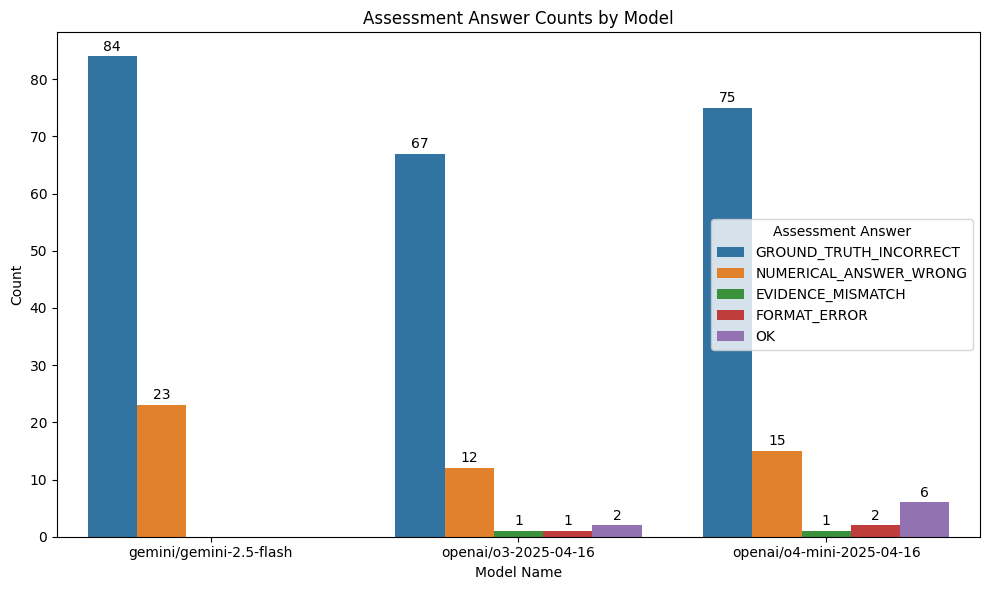

In [490]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(judge_results)
grouped = (
    df.groupby(["model_name", "assessment_answer"]).size().reset_index(name="count")
)
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped, x="model_name", y="count", hue="assessment_answer")
plt.title("Assessment Answer Counts by Model")
plt.ylabel("Count")
plt.xlabel("Model Name")
plt.legend(title="Assessment Answer")
plt.tight_layout()

# Add value annotations
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{int(height)}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
            xytext=(0, 2),
            textcoords="offset points",
        )

plt.show()

In [502]:
df.to_csv('./judge_results/gate_and_probe_judge_results.csv', index=False)

From the analysis above, we see that:
- Majority of the errors for all our selected models are due to **incorrect ground truth**. 
- We also see cases where the model was unable to generate the answer in the format as expected by the ground truth. 
- Finally, somewhat surpringly, we see some results marked as "OK", even though we only selected records that didn't match the ground truth using our _exact match_ metric.

Let's look through this more closely:

In [503]:
df[df["assessment_answer"] == "GROUND_TRUTH_INCORRECT"]

,id,model_name,question,ground_truth_answer,predicted_answer,assessment_answer,assessment_reasoning
0,Single_ETR/2011/page_22.pdf-3,openai/o4-mini-2025-04-16,so what was the percentage change during this time?,7.605000e-02,7.6%,GROUND_TRUTH_INCORRECT,"The question asks for a ""percentage change"". The model correctly c..."
1,Single_ETR/2004/page_258.pdf-4,openai/o4-mini-2025-04-16,what is the percent change?,1.473800e-01,14.7%,GROUND_TRUTH_INCORRECT,"The question asks for the ""percent change"". The predicted answer p..."
3,Single_ADI/2011/page_83.pdf-2,openai/o4-mini-2025-04-16,what growth rate does this represent?,8.290600e-01,82.9%,GROUND_TRUTH_INCORRECT,"The question asks for a 'growth rate', which is typically expresse..."
4,Single_CB/2008/page_243.pdf-3,openai/o4-mini-2025-04-16,what was the percent change?,7.368000e-02,7.37,GROUND_TRUTH_INCORRECT,"The question asks for the ""percent change"". The model correctly ca..."
5,Single_AMT/2015/page_50.pdf-1,openai/o4-mini-2025-04-16,what was the low for share price for the quarter ended 12/31/15?,8.732000e+01,90.2,GROUND_TRUTH_INCORRECT,The question asks for the low share price for the quarter ended 12...
...,...,...,...,...,...,...,...
282,Single_SLG/2017/page_114.pdf-3,openai/o3-2025-04-16,so what was the percentage of pension plan contributions out of th...,2.302800e-01,23.03,GROUND_TRUTH_INCORRECT,"The question asks for a ""percentage"". The model correctly calculat..."
283,Single_JPM/2008/page_177.pdf-4,openai/o3-2025-04-16,"what was the total amount of resale agreements in 2008, in millions?",2.080000e+04,"200,265",GROUND_TRUTH_INCORRECT,The question asks for the 'total amount of resale agreements in 20...
284,Double_IPG/2014/page_95.pdf,openai/o3-2025-04-16,and what is it for the the 2009 one?,1.218121e+07,435259,GROUND_TRUTH_INCORRECT,"The question asks for the value for ""the 2009 one"". The previous t..."
286,Single_APTV/2018/page_36.pdf-2,openai/o3-2025-04-16,how much does the change in the value of the aptiv plc represent i...,3.080000e-01,30.8%,GROUND_TRUTH_INCORRECT,"The question asks for the answer ""in percentage"". The model correc..."


# Conclusion

Curriculum-first pass surfaced a gap between our metric and reality. Several "errors" are actually correct answers hidden by formatting. Manual review shows many EM misses are due to surface form, not reasoning.

There are also cases where the ground-truth in the dataset is incorrect.

**What broke EM**

- Numeric formatting: thousands separators, “0.5M” vs “500000”.
- Units and scaling: $, %, M/B suffixes; percent vs decimal.
- Rounding/tolerance: 2dp rounding vs full precision.
- Boolean variants: yes/true/1 vs no/false/0.

The above results are **not conclusive** by any means, since the LLM-as-a-judge approach also has known flaws. However, it does give us some pointers on how to improve the model performance from here!

**Note**: LLM-as-judge remains imperfect. We’ll retain periodic human spot-checks. With cleaner metrics and logging, the next step is to test if DSPy’s optimizers actually lift EM under the Easy→Medium→Hard schedule without inflating token cost.
